In [32]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\zakaria\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [33]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [34]:
df = pd.read_csv('data_llhajbb.csv',sep=',' )

AUTO = tf.data.experimental.AUTOTUNE

In [35]:
df.head()

,path_image,lebel
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [36]:
a=df.copy()
a=pd.get_dummies(a['lebel'])
df1=pd.concat([df, a], axis=1)
df1.head()

,path_image,lebel,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,puceron vert,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,0,1,0


In [37]:
data=df1[df1['puceron noir']!=1]

In [38]:
data=data[data['scolytes']!=1]
data=data[data['puceron vert']!=1]

In [39]:
data.drop(columns='lebel', inplace=True)

data.shape

(402, 11)

In [40]:
data.drop(columns=['puceron noir','scolytes','puceron vert'],inplace=True)

In [41]:
data.head()

,path_image,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,rouille
0,new_data0.jpeg,0,0,0,0,0,0,1
1,new_data1.jpeg,0,0,0,0,0,0,1
2,new_data2.jpeg,0,0,0,0,0,0,1
3,new_data3.jpeg,0,0,0,0,0,0,1
4,new_data4.jpeg,0,0,0,0,0,0,1


In [42]:
data.columns

Index(['path_image', 'acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille'],
      dtype='object')

<ipython-input-43-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()


<AxesSubplot:ylabel='None'>

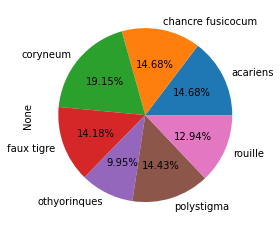

In [43]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [44]:
img_size={'height': 960,
         'width': 1280 }

In [45]:
data.shape

(402, 8)

In [46]:
path='paths/'
data_path=data.path_image.apply(lambda x: path +x).values

(1280, 958, 3)


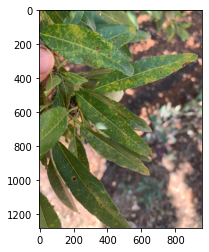

In [47]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [48]:
data_path

array(['paths/new_data0.jpeg', 'paths/new_data1.jpeg',
       'paths/new_data2.jpeg', 'paths/new_data3.jpeg',
       'paths/new_data4.jpeg', 'paths/new_data5.jpeg',
       'paths/new_data6.jpeg', 'paths/new_data7.jpeg',
       'paths/new_data8.jpeg', 'paths/new_data9.jpeg',
       'paths/new_data10.jpeg', 'paths/new_data11.jpeg',
       'paths/new_data12.jpeg', 'paths/new_data13.jpeg',
       'paths/new_data14.jpeg', 'paths/new_data15.jpeg',
       'paths/new_data16.jpeg', 'paths/new_data17.jpeg',
       'paths/new_data18.jpeg', 'paths/new_data19.jpeg',
       'paths/new_data20.jpeg', 'paths/new_data21.jpeg',
       'paths/new_data22.jpeg', 'paths/new_data23.jpeg',
       'paths/new_data24.jpeg', 'paths/new_data25.jpeg',
       'paths/new_data26.jpeg', 'paths/new_data27.jpeg',
       'paths/new_data28.jpeg', 'paths/new_data29.jpeg',
       'paths/new_data30.jpeg', 'paths/new_data31.jpeg',
       'paths/new_data32.jpeg', 'paths/new_data33.jpeg',
       'paths/new_data34.jpeg', 'paths/ne

In [49]:
data_labels = data.loc[:, ['acariens', 'chancre fusicocum', 'faux tigre','othyorinques', 'polystigma','coryneum', 'rouille']].values

In [50]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [51]:
len(test_paths)

81

In [52]:
IMG_SIZE=300
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [53]:
BATCH_SIZE = 8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [54]:
LR_START = 0.0001
LR_MAX = 0.00005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [57]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('ResNet152')


In [58]:
Dense_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [59]:
x = Dense_net.get_layer("global_average_pooling2d").output

x = tf.keras.layers.Dense(1000, activation='softmax')(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [61]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // 8,
    epochs=80,
    validation_data=test_dataset
    )

Epoch 1/80
50/50 [==============================] - 28s 543ms/step - loss: 1.7570 - accuracy: 0.2825 - val_loss: 1.8174 - val_accuracy: 0.1605
Epoch 2/80
50/50 [==============================] - 27s 543ms/step - loss: 1.7438 - accuracy: 0.3075 - val_loss: 2.0098 - val_accuracy: 0.0617
Epoch 3/80
50/50 [==============================] - 27s 540ms/step - loss: 1.7403 - accuracy: 0.3225 - val_loss: 1.9369 - val_accuracy: 0.1235
Epoch 4/80
50/50 [==============================] - 27s 541ms/step - loss: 1.7896 - accuracy: 0.2875 - val_loss: 2.0125 - val_accuracy: 0.1111
Epoch 5/80
50/50 [==============================] - 27s 541ms/step - loss: 1.7444 - accuracy: 0.3025 - val_loss: 1.9603 - val_accuracy: 0.1358
Epoch 6/80
50/50 [==============================] - 27s 542ms/step - loss: 1.7239 - accuracy: 0.3250 - val_loss: 1.8221 - val_accuracy: 0.1605
Epoch 7/80
50/50 [==============================] - 27s 545ms/step - loss: 1.7309 - accuracy: 0.3225 - val_loss: 2.0200 - val_accuracy: 0.1111

In [62]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

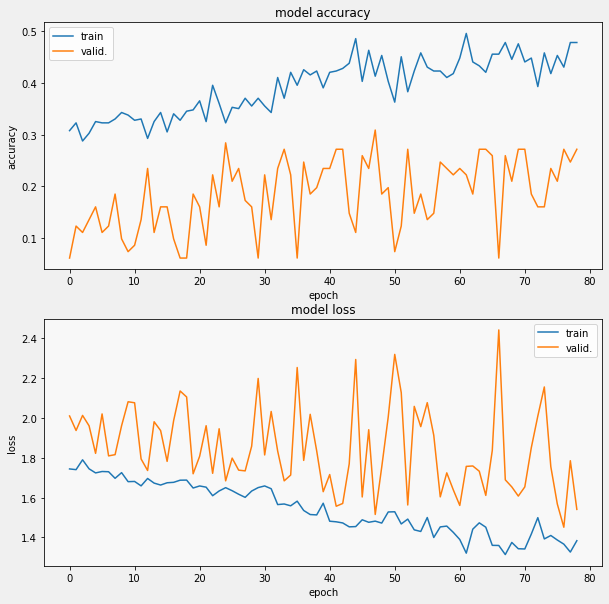

In [63]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [64]:
import pickle
with open('training_log/ResNet152_newdata408_withlayer_300px.pkl', 'wb') as output:
        pickle.dump(history.history, output)